In [10]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os

from BDTHelper import getDataFromFVV, BDT, LEEweights

with open("BDTWeights/old/BDT_1e1p_Run1_6-2-20.pickle","rb") as handle: r1bdt_old = pickle.load(handle)
with open("BDTWeights/old/BDT_1e1p_Run3_6-2-20.pickle","rb") as handle: r3bdt_old = pickle.load(handle)

oldbdt = {1:r1bdt_old,2:r3bdt_old,3:r3bdt_old}

In [11]:
#Load the files

# set the BDT you want to train
addPostcuts = False
newCalib = True
applyGoodReco = True
Ecut = None
fullLowE = True
withPi0Samples = True
trainAgainstNues = False
useLEEweights = False
useEnu = False

traintestsplit = 0.5
nBDTs = 20
dirtag = '7July2021_vA_fullLowE_withPi0Sample_newShowerCalib_noEnu'
datadir = '/home/nwkamp/Research/MicroBooNE/Data/'

filelist = {}
filetags = {}

filelist[1] = ['run1_intrinsics_rerun_stripmine.root',
               'run1_overlay_stripmine.root',
               'mcc9_v28_wctagger_extbnb_finalbdt.root',
               'mcc9_v29e_run1_bnb_intrinsic_nue_overlay_LowE.root',
               'mcc9_v29e_run1_bnb_nu_overlay_LowE.root']

filelist[2] = ['mcc9_v29e_dl_run2_bnb_intrinsics_nue_overlay_finalbdt.root',
               'run2_overlay_stripmine.root',
               'mcc9_v29e_dl_run3_G1_extbnb_finalbdt.root',
               'mcc9_intrinsic_nue_lowe_run2_fvv_stripped.root',
               'mcc9_bnb_overlay_lowe_run2_fvv_stripped.root']

filelist[3] = ['mcc9_v29e_run3b_bnb_intrinsic_nue_overlay_nocrtremerge.root',
               'mcc9_v29e_dl_run3b_bnb_nu_overlay_nocrtremerge_finalbdt.root',
               'mcc9_v29e_dl_run3_G1_extbnb_finalbdt.root',
               'mcc9_v29e_dl_run3b_intrinsic_nue_LowE.root',
               'mcc9_v29e_run3b_bnb_nu_overlay_LowE.root']

filetags[1] = ['intrinsics',
               'overlay',
               'ext',
               'intrinsics_lowE',
               'overlay_lowE']

filetags[2] = ['intrinsics',
               'overlay',
               'ext',
               'intrinsics_lowE',
               'overlay_lowE']

filetags[3] = ['intrinsics',
               'overlay',
               'ext',
               'intrinsics_lowE',
               'overlay_lowE']

POT = {}

POT[1] = [1.15690338134E+23,
          1.33681555217E+21,
          22474918.0 / 9776965.0 * 4.403e19 * 64907./63119.,
          6.05398370114e+23,
          1.63103516179e+21]

POT[2] = [9.2085012316e+22,
          1.29919202522E+21,
          39566274.0 / 2263559.0 * 8.786e+18,
          7.497617079E+23,
          2.0290756497E+21]

POT[3] = [4.70704675581e+22 * 100438./100186.,
          8.98773223801e+20 * 314302./318046.,
          39566274.0 / 2263559.0 * 8.786e+18,
          5.97440749241e+23,
          1.51234621011e+21]
        
if withPi0Samples:
    
    filelist[1] += ['mcc9_v40_CCPi0_run1_dlana_stripped_v2.root',
                    'mcc9_v40_NCPi0_run1_dlana_stripped_v2.root']
    filelist[2] += ['mcc9_v40_CCPi0_run3_dlana_stripped_v2.root',
                    'mcc9_v40_NCPi0_run3_dlana_stripped_v2.root']
    filelist[3] += ['mcc9_v40_CCPi0_run3_dlana_stripped_v2.root',
                    'mcc9_v40_NCPi0_run3_dlana_stripped_v2.root']
    
    filetags[1] += ['ccpi0', 'ncpi0']
    filetags[2] += ['ccpi0', 'ncpi0']
    filetags[3] += ['ccpi0', 'ncpi0']
    
    POT[1] += [6.91412E+20, 2.90763E+21]
    POT[2] += [5.91343E+20, 2.22482E+21 + 2.64479e+20]
    POT[3] += [5.91343E+20, 2.22482E+21 + 2.64479e+20]


train_x,train_y = ({1:{i:[] for i in range(nBDTs)},2:{i:[] for i in range(nBDTs)},3:{i:[] for i in range(nBDTs)}},
                   {1:{i:[] for i in range(nBDTs)},2:{i:[] for i in range(nBDTs)},3:{i:[] for i in range(nBDTs)}})
val_x,val_y = ({1:{i:[] for i in range(nBDTs)},2:{i:[] for i in range(nBDTs)},3:{i:[] for i in range(nBDTs)}},
               {1:{i:[] for i in range(nBDTs)},2:{i:[] for i in range(nBDTs)},3:{i:[] for i in range(nBDTs)}})

train_w,val_w = ({1:{i:[] for i in range(nBDTs)},2:{i:[] for i in range(nBDTs)},3:{i:[] for i in range(nBDTs)}},
                 {1:{i:[] for i in range(nBDTs)},2:{i:[] for i in range(nBDTs)},3:{i:[] for i in range(nBDTs)}})

train_pot,val_pot = ({1:{i:[] for i in range(nBDTs)},2:{i:[] for i in range(nBDTs)},3:{i:[] for i in range(nBDTs)}},
                     {1:{i:[] for i in range(nBDTs)},2:{i:[] for i in range(nBDTs)},3:{i:[] for i in range(nBDTs)}})

train_rse,val_rse = ({1:{i:{} for i in range(nBDTs)},2:{i:{} for i in range(nBDTs)},3:{i:{} for i in range(nBDTs)}},
                     {1:{i:{} for i in range(nBDTs)},2:{i:{} for i in range(nBDTs)},3:{i:{} for i in range(nBDTs)}})

for r in [1,2,3]:
    print('\nRUN',r)
    for f,pot,tag in zip(filelist[r],POT[r],filetags[r]):
        print(f)
        treestr = 'FinalVertexVariables' if 'stripmine' in f else None
        tts = traintestsplit
        if fullLowE and 'lowE' in tag: tts = 1.0
        elif r==2 and ('pi0' in tag or 'ext' in tag): tts = 1.0
        for b in range(nBDTs):
            print('BDT',b)
            tx,ty,trse,vx,vy,vrse = getDataFromFVV(datadir+f,tts,
                                                   newCalib=newCalib,
                                                   addPostcuts=addPostcuts,
                                                   Ecut=Ecut,
                                                   applyGoodReco=applyGoodReco,
                                                   trainAgainstNues=trainAgainstNues,
                                                   treestr=treestr,
                                                   useEnu=useEnu)
            train_x[r][b] += tx
            train_y[r][b]  += ty
            try:
                if useLEEweights:
                    train_w[r][b] += list(LEEweights(np.array(tx)[:,0]))
                else:
                    train_w[r][b] += list(np.ones_like(tx[:,0]))
            except: train_w[r][b] += []
            train_pot[r][b] += [pot for _ in range(len(ty))]
            train_rse[r][b][tag] = trse
            val_x[r][b]  += vx
            val_y[r][b]  += vy
            try: 
                if useLEEweights:
                    val_w[r][b] += list(LEEweights(np.array(vx)[:,0]))
                else:
                    val_w[r][b] += list(np.ones_like(vx[:,0]))
            except: val_w[r][b] += []  
            val_pot[r][b] += [pot for _ in range(len(vy))]
            val_rse[r][b][tag] = vrse
            print('Train sig/bkg:',sum(ty),len(ty)-sum(ty))
            print('Val sig/bkg:',sum(vy),len(vy)-sum(vy))


RUN 1
run1_intrinsics_rerun_stripmine.root
BDT 0
Train sig/bkg: 3452 0
Val sig/bkg: 3452 0
BDT 1
Train sig/bkg: 3452 0
Val sig/bkg: 3452 0
BDT 2
Train sig/bkg: 3452 0
Val sig/bkg: 3452 0
BDT 3
Train sig/bkg: 3452 0
Val sig/bkg: 3452 0
BDT 4
Train sig/bkg: 3452 0
Val sig/bkg: 3452 0
BDT 5
Train sig/bkg: 3452 0
Val sig/bkg: 3452 0
BDT 6
Train sig/bkg: 3452 0
Val sig/bkg: 3452 0
BDT 7
Train sig/bkg: 3452 0
Val sig/bkg: 3452 0
BDT 8
Train sig/bkg: 3452 0
Val sig/bkg: 3452 0
BDT 9
Train sig/bkg: 3452 0
Val sig/bkg: 3452 0
BDT 10
Train sig/bkg: 3452 0
Val sig/bkg: 3452 0
BDT 11
Train sig/bkg: 3452 0
Val sig/bkg: 3452 0
BDT 12
Train sig/bkg: 3452 0
Val sig/bkg: 3452 0
BDT 13
Train sig/bkg: 3452 0
Val sig/bkg: 3452 0
BDT 14
Train sig/bkg: 3452 0
Val sig/bkg: 3452 0
BDT 15
Train sig/bkg: 3452 0
Val sig/bkg: 3452 0
BDT 16
Train sig/bkg: 3452 0
Val sig/bkg: 3452 0
BDT 17
Train sig/bkg: 3452 0
Val sig/bkg: 3452 0
BDT 18
Train sig/bkg: 3452 0
Val sig/bkg: 3452 0
BDT 19
Train sig/bkg: 3452 0
Val si

Train sig/bkg: 37 12824
Val sig/bkg: 34 12828
BDT 4
Train sig/bkg: 34 12827
Val sig/bkg: 37 12825
BDT 5
Train sig/bkg: 40 12821
Val sig/bkg: 31 12831
BDT 6
Train sig/bkg: 38 12823
Val sig/bkg: 33 12829
BDT 7
Train sig/bkg: 28 12833
Val sig/bkg: 43 12819
BDT 8
Train sig/bkg: 43 12818
Val sig/bkg: 28 12834
BDT 9
Train sig/bkg: 39 12822
Val sig/bkg: 32 12830
BDT 10
Train sig/bkg: 39 12822
Val sig/bkg: 32 12830
BDT 11
Train sig/bkg: 38 12823
Val sig/bkg: 33 12829
BDT 12
Train sig/bkg: 33 12828
Val sig/bkg: 38 12824
BDT 13
Train sig/bkg: 35 12826
Val sig/bkg: 36 12826
BDT 14
Train sig/bkg: 36 12825
Val sig/bkg: 35 12827
BDT 15
Train sig/bkg: 36 12825
Val sig/bkg: 35 12827
BDT 16
Train sig/bkg: 30 12831
Val sig/bkg: 41 12821
BDT 17
Train sig/bkg: 45 12816
Val sig/bkg: 26 12836
BDT 18
Train sig/bkg: 28 12833
Val sig/bkg: 43 12819
BDT 19
Train sig/bkg: 35 12826
Val sig/bkg: 36 12826
mcc9_v29e_dl_run3_G1_extbnb_finalbdt.root
BDT 0
Train sig/bkg: 0 2299
Val sig/bkg: 0 0
BDT 1
Train sig/bkg: 0 22

Train sig/bkg: 0 1149
Val sig/bkg: 0 1150
BDT 10
Train sig/bkg: 0 1149
Val sig/bkg: 0 1150
BDT 11
Train sig/bkg: 0 1149
Val sig/bkg: 0 1150
BDT 12
Train sig/bkg: 0 1149
Val sig/bkg: 0 1150
BDT 13
Train sig/bkg: 0 1149
Val sig/bkg: 0 1150
BDT 14
Train sig/bkg: 0 1149
Val sig/bkg: 0 1150
BDT 15
Train sig/bkg: 0 1149
Val sig/bkg: 0 1150
BDT 16
Train sig/bkg: 0 1149
Val sig/bkg: 0 1150
BDT 17
Train sig/bkg: 0 1149
Val sig/bkg: 0 1150
BDT 18
Train sig/bkg: 0 1149
Val sig/bkg: 0 1150
BDT 19
Train sig/bkg: 0 1149
Val sig/bkg: 0 1150
mcc9_v29e_dl_run3b_intrinsic_nue_LowE.root
BDT 0
Train sig/bkg: 2159 0
Val sig/bkg: 0 0
BDT 1
Train sig/bkg: 2159 0
Val sig/bkg: 0 0
BDT 2
Train sig/bkg: 2159 0
Val sig/bkg: 0 0
BDT 3
Train sig/bkg: 2159 0
Val sig/bkg: 0 0
BDT 4
Train sig/bkg: 2159 0
Val sig/bkg: 0 0
BDT 5
Train sig/bkg: 2159 0
Val sig/bkg: 0 0
BDT 6
Train sig/bkg: 2159 0
Val sig/bkg: 0 0
BDT 7
Train sig/bkg: 2159 0
Val sig/bkg: 0 0
BDT 8
Train sig/bkg: 2159 0
Val sig/bkg: 0 0
BDT 9
Train sig/bkg:

[Errno 17] File exists: 'Plots/7July2021_vA_fullLowE_withPi0Sample_newShowerCalib_noEnu/'
[Errno 17] File exists: 'Plots/7July2021_vA_fullLowE_withPi0Sample_newShowerCalib_noEnu/InputVarbs/'


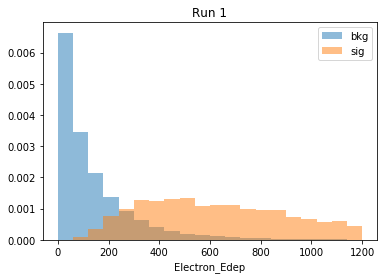

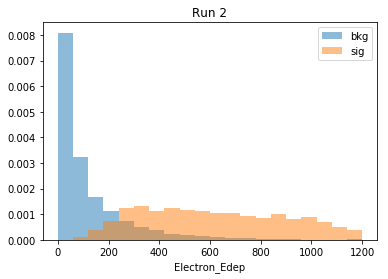

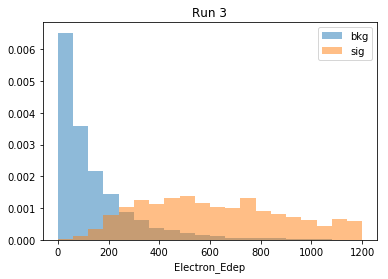

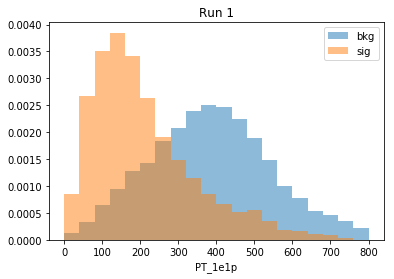

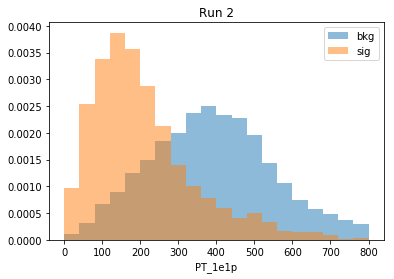

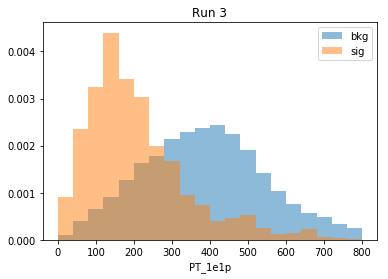

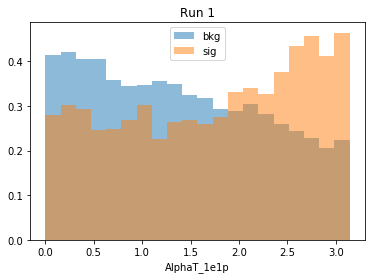

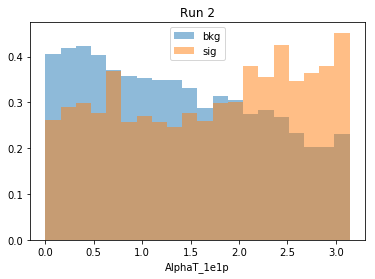

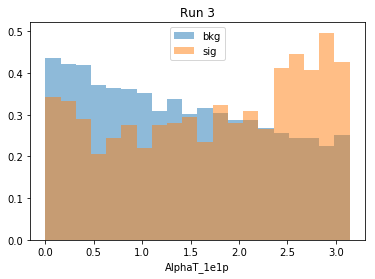

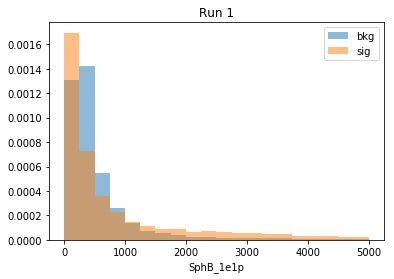

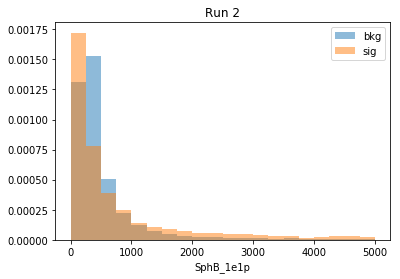

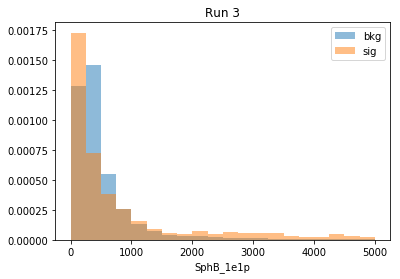

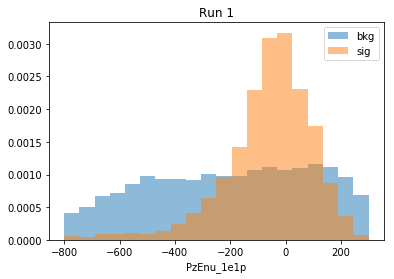

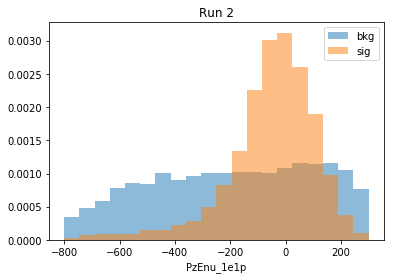

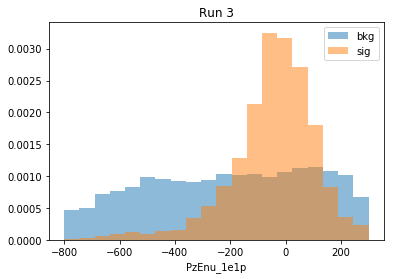

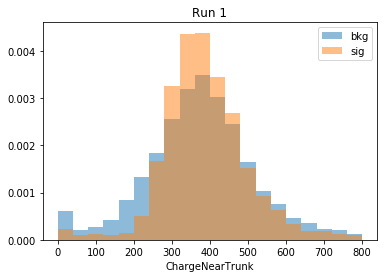

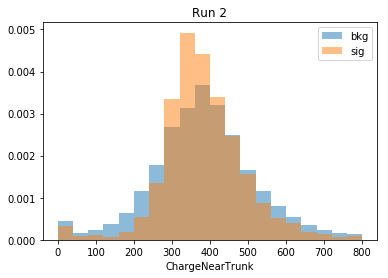

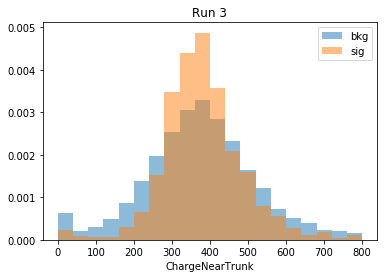

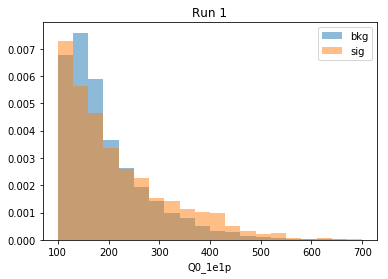

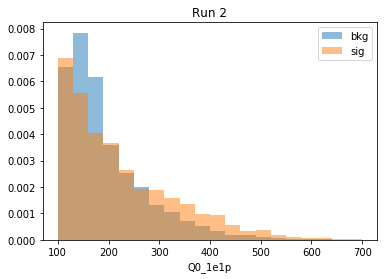

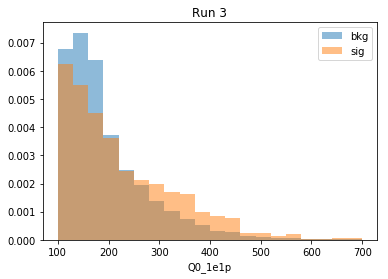

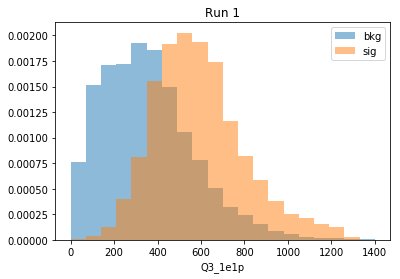

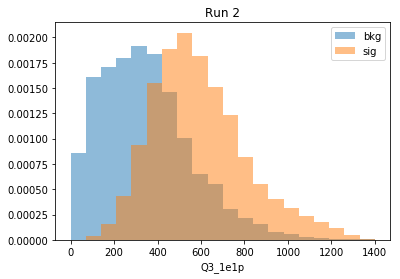

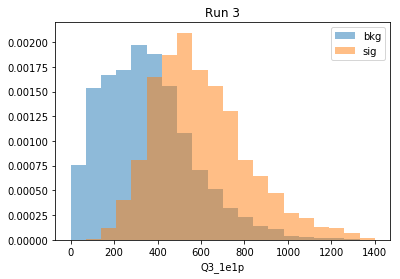

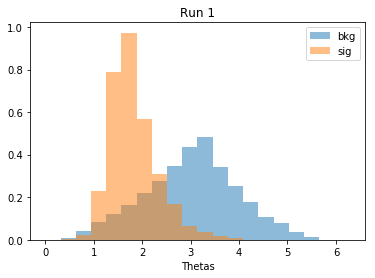

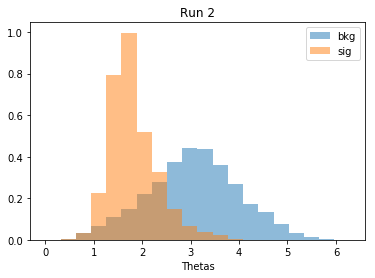

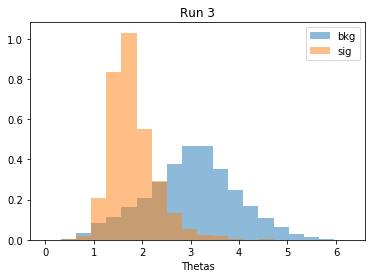

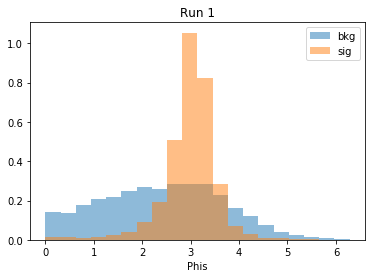

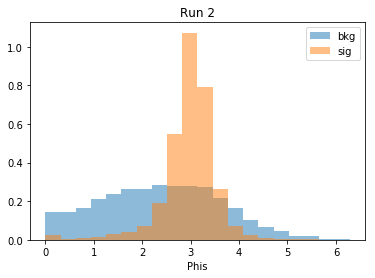

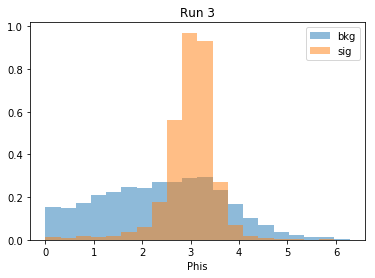

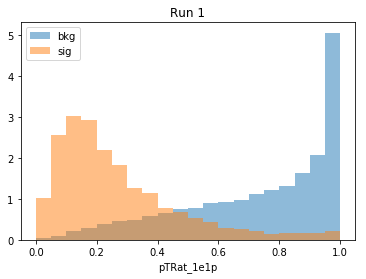

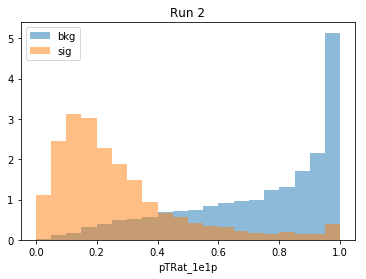

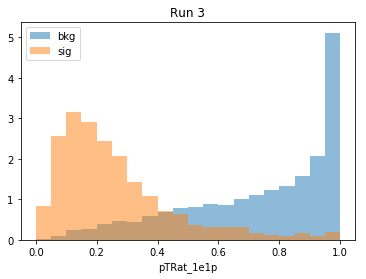

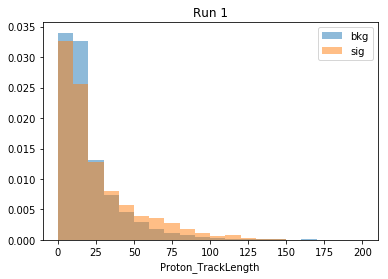

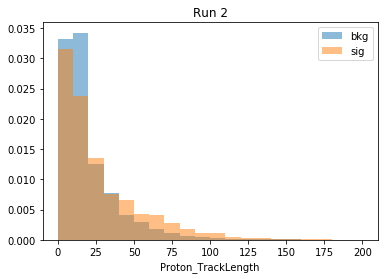

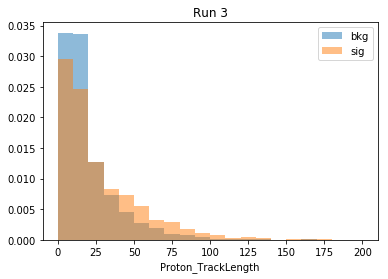

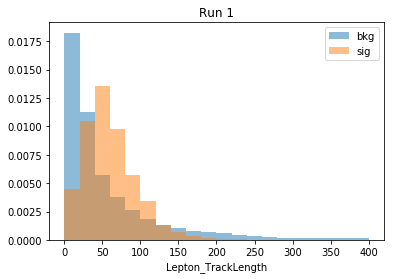

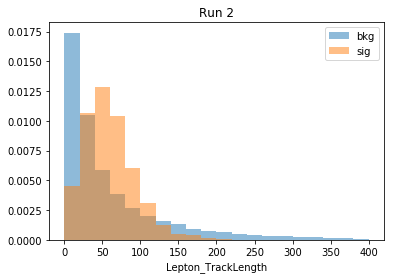

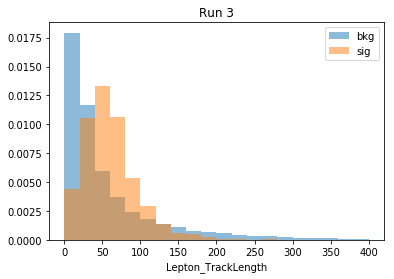

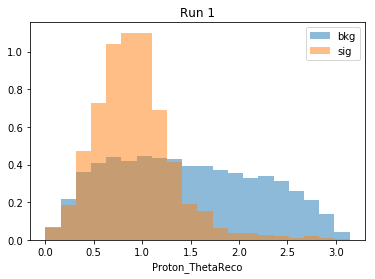

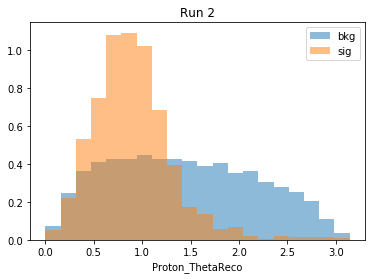

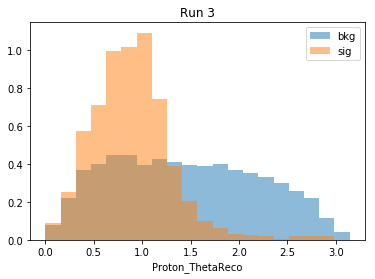

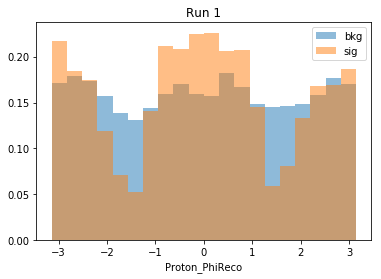

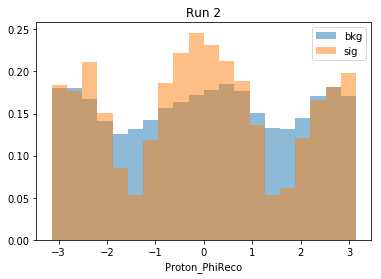

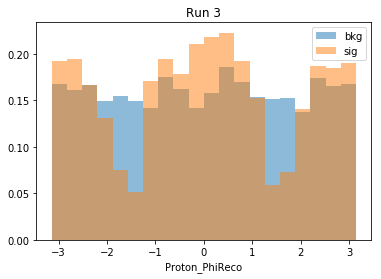

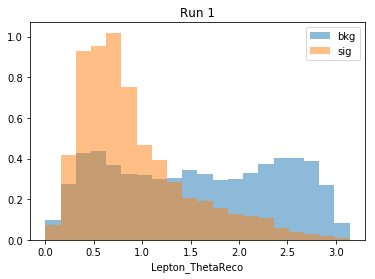

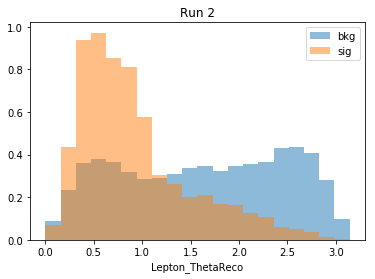

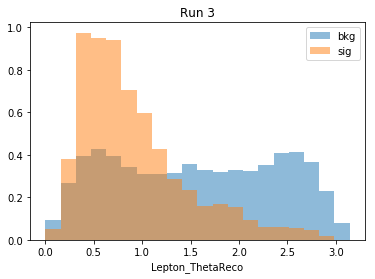

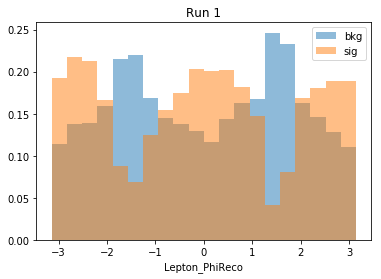

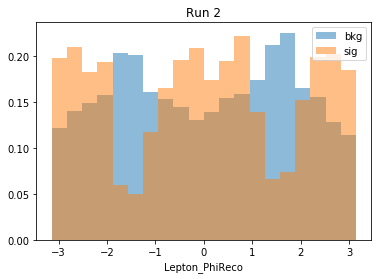

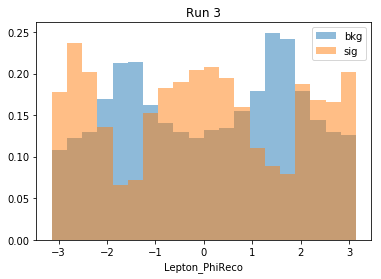

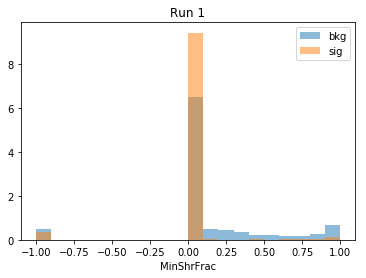

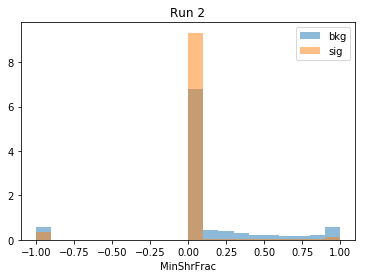

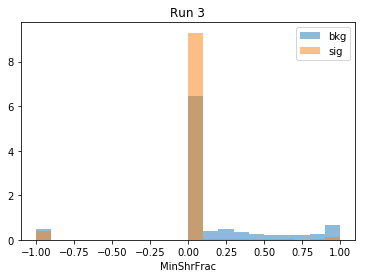

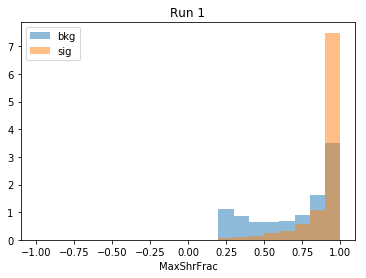

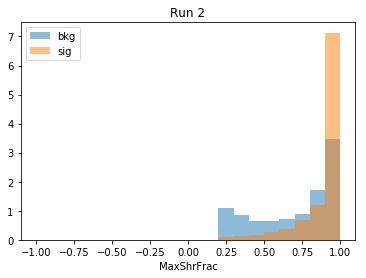

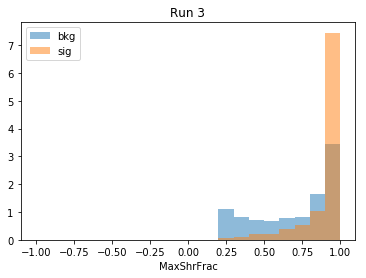

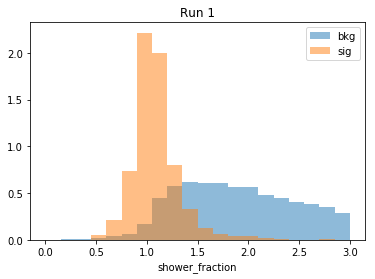

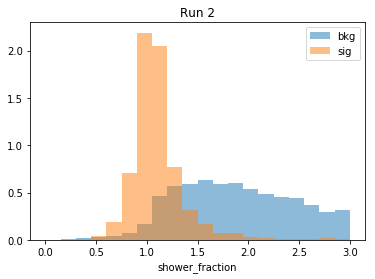

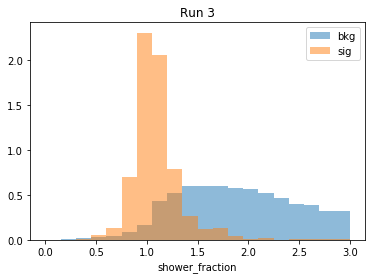

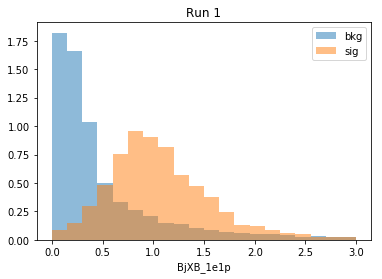

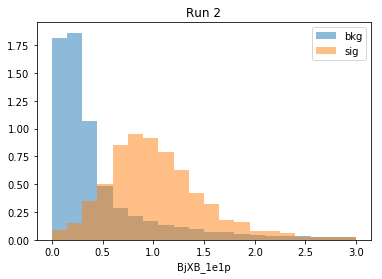

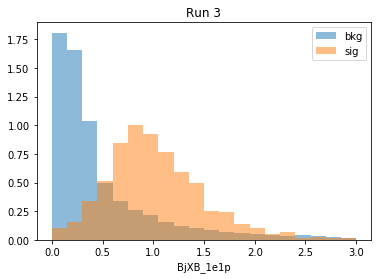

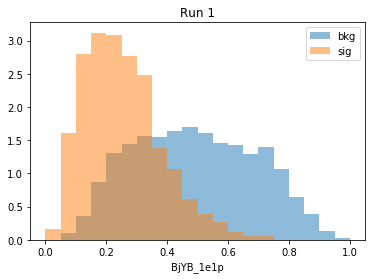

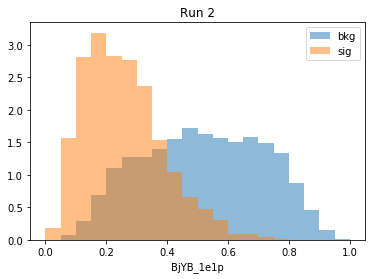

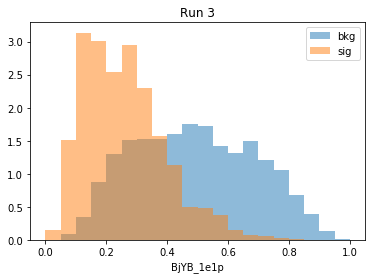

In [12]:
savedir = 'Plots/'+dirtag+'/'
try:
    os.mkdir(savedir)
except OSError as error:
    print(error)
savedir = 'Plots/'+dirtag+'/InputVarbs/'
try:
    os.mkdir(savedir)
except OSError as error:
    print(error)

# Look at all the input variables
variableTitles = ['Enu_1e1p', 'Electron_Edep', 'PT_1e1p', 'AlphaT_1e1p', 'SphB_1e1p', 'PzEnu_1e1p', 'ChargeNearTrunk',
            'Q0_1e1p', 'Q3_1e1p', 'Thetas', 'Phis', 'pTRat_1e1p', 'Proton_TrackLength', 'Lepton_TrackLength',
            'Proton_ThetaReco', 'Proton_PhiReco', 'Lepton_ThetaReco', 'Lepton_PhiReco', 'MinShrFrac',
            'MaxShrFrac','shower_fraction' , 'BjXB_1e1p', 'BjYB_1e1p']
ranges = [ (0,1200),(0,1200),(0,800),(0,np.pi),(0,5000),(-800,300),
           (0,800),(100,700),(0,1400),(0,2*np.pi),(0,2*np.pi),
           (0,1),(0,200),(0,400),(0,np.pi),(-np.pi,np.pi),(0,np.pi),(-np.pi,np.pi),
           (-1,1),(-1,1),(0,3),(0,3),(0,1)]

if not useEnu:
    variableTitles = variableTitles[1:]
    ranges = ranges[1:]

for i,(var,r) in enumerate(zip(variableTitles,ranges)):
    for run in [1,2,3]:
        idxbkg = [_y==0 for _y in val_y[run][0]]
        idxsig = [_y==1 for _y in val_y[run][0]]
        plt.hist((np.array(val_x[run][0])[:,i])[idxbkg],range=(r[0],r[-1]),bins=20,label='bkg',alpha=0.5,normed=1)
        plt.hist((np.array(val_x[run][0])[:,i])[idxsig],range=(r[0],r[-1]),bins=20,label='sig',alpha=0.5,normed=1)
        plt.legend()
        plt.xlabel(var)
        plt.title('Run %i'%run)
        plt.savefig(savedir+'%s_Run%i.png'%(var,run),dpi=100)
        plt.show()

In [13]:
# Make BDT
bdt = {1:{},2:{},3:{}}
for r in [1,2,3]:
    for b in range(nBDTs):
        bdt[r][b] = BDT()
        bdt[r][b].initialize(dirtag,v=1)

In [14]:
# Train!
for r in [1,2,3]:
    for b in range(nBDTs):
        tx = np.array(train_x[r][b])
        ty = np.array(train_y[r][b])
        tw = np.array(train_w[r][b])
        vx = np.array(val_x[r][b])
        vy = np.array(val_y[r][b])
        vw = np.array(val_w[r][b])
        print('Training run %i bdt %i on %i/%i sig/bkg events'% (r,b,sum(ty),sum(np.logical_not(ty))))
        eval_set = [(vx,vy)]
        eval_w = [vw]
        bdt[r][b].model.fit(tx,ty,sample_weight=tw,eval_set=eval_set,sample_weight_eval_set=eval_w,
                            early_stopping_rounds=50, eval_metric='error',verbose=False)

Training run 1 bdt 0 on 5690/18238 sig/bkg events
Training run 1 bdt 1 on 5693/18235 sig/bkg events
Training run 1 bdt 2 on 5690/18238 sig/bkg events
Training run 1 bdt 3 on 5689/18239 sig/bkg events
Training run 1 bdt 4 on 5680/18248 sig/bkg events
Training run 1 bdt 5 on 5693/18235 sig/bkg events
Training run 1 bdt 6 on 5686/18242 sig/bkg events
Training run 1 bdt 7 on 5690/18238 sig/bkg events
Training run 1 bdt 8 on 5688/18240 sig/bkg events
Training run 1 bdt 9 on 5684/18244 sig/bkg events
Training run 1 bdt 10 on 5692/18236 sig/bkg events
Training run 1 bdt 11 on 5690/18238 sig/bkg events
Training run 1 bdt 12 on 5686/18242 sig/bkg events
Training run 1 bdt 13 on 5691/18237 sig/bkg events
Training run 1 bdt 14 on 5689/18239 sig/bkg events
Training run 1 bdt 15 on 5689/18239 sig/bkg events
Training run 1 bdt 16 on 5691/18237 sig/bkg events
Training run 1 bdt 17 on 5693/18235 sig/bkg events
Training run 1 bdt 18 on 5694/18234 sig/bkg events
Training run 1 bdt 19 on 5680/18248 sig/b

In [15]:
savedir = 'BDTWeights/new/'+dirtag+'/'
try:
    os.mkdir(savedir)
except OSError as error:
    print(error) 

for r in [1,2,3]:
    for b in range(nBDTs):
        pickle.dump(bdt[r][b].model,open(savedir+'BDTweights_R%i_%i.pickle'%(r,b),'wb'))
        for tag,rselist in train_rse[r][b].items():
            ft = open(savedir+'TrainSample_R%i_%i_%s.txt'%(r,b,tag),'w')
            for rse in rselist:
                print(rse[0],rse[1],rse[2],file=ft)
        for tag,rselist in val_rse[r][b].items():
            fv = open(savedir+'ValSample_R%i_%i_%s.txt'%(r,b,tag),'w')
            for rse in rselist:
                print(rse[0],rse[1],rse[2],file=fv)
        ft.close()
        fv.close()

[Errno 17] File exists: 'BDTWeights/new/7July2021_vA_fullLowE_withPi0Sample_newShowerCalib_noEnu/'


In [16]:
C1_POT = 1.558e+20 + 1.129e+17 + 1.869e+19
D2_POT = 1.63e+20 + 2.964e+19 + 1.239e+19
E1_POT = 5.923e+19
F1_POT = 4.3e+19
G1_POT = 1.701e+20 + 2.97e+19 + 1.524e+17

DAT_POT1 = C1_POT
DAT_POT2 = E1_POT+D2_POT
DAT_POT3 = F1_POT+G1_POT

POT_scale = {1:DAT_POT1,2:DAT_POT2,3:DAT_POT3}

def makeplots(inpx,inpy,inPOT,tag):
    
    savedir = 'Plots/'+dirtag+'/'+tag+'/'
    try:
        os.mkdir(savedir)
    except OSError as error:
        print(error) 
    
    for r in [1,2,3]:
        for ib in range(nBDTs):
            inx = np.array(inpx[r][ib])
            iny = np.array(inpy[r][ib])
            inpot = np.array(inPOT[r][ib])
            y = bdt[r][ib].model.predict_proba(np.array(inx))[:,1]
            sig_indices = [_y==1 for _y in iny]
            bkg_indices = [_y==0 for _y in iny]
            ysig = y[sig_indices]
            ybkg = y[bkg_indices]
            wsig = np.array([POT_scale[r]/pot for pot in inpot])
            wsig = wsig[sig_indices]
            wbkg = np.array([POT_scale[r]/pot for pot in inpot])
            wbkg = wbkg[bkg_indices]

            yold = oldbdt[r].predict_proba(np.array(inx))[:,0]
            ysig_old = yold[sig_indices]
            ybkg_old = yold[bkg_indices]

            plt.hist(ysig,bins=10,range=(0,1),alpha=0.5,label='sig')
            plt.hist(ybkg,bins=10,range=(0,1),alpha=0.5,label='bkg')
            plt.xlabel('BDT Score')
            plt.ylabel('Raw MC count')
            plt.title('RUN %i: NEW' % r)
            plt.legend()
            plt.semilogy()
            plt.savefig(savedir+'rawSigBkgNew_r%i_%i.png'%(r,ib),dpi=100)
            plt.show()

            plt.hist(ysig_old,bins=10,range=(0,1),alpha=0.5,label='sig')
            plt.hist(ybkg_old,bins=10,range=(0,1),alpha=0.5,label='bkg')
            plt.xlabel('BDT Score')
            plt.ylabel('Raw MC count')
            plt.title('RUN %i: OLD' % r)
            plt.legend()
            plt.semilogy()
            plt.savefig(savedir+'rawSigBkgOld_r%i_%i.png'%(r,ib),dpi=100)
            plt.show()

            plt.hist(ysig,bins=10,range=(0,1),alpha=0.5,label='sig',weights=wsig)
            plt.hist(ybkg,bins=10,range=(0,1),alpha=0.5,label='bkg',weights=wbkg)
            plt.xlabel('BDT Score')
            plt.ylabel('Events / POT')
            plt.title('RUN %i: NEW' % r)
            plt.legend()
            plt.semilogy()
            plt.savefig(savedir+'potSigBkgNew_r%i_%i.png'%(r,ib),dpi=100)
            plt.show()

            plt.hist(ysig_old,bins=10,range=(0,1),alpha=0.5,label='sig',weights=wsig)
            plt.hist(ybkg_old,bins=10,range=(0,1),alpha=0.5,label='bkg',weights=wbkg)
            plt.xlabel('BDT Score')
            plt.ylabel('Events / POT')
            plt.title('RUN %i: OLD' % r)
            plt.legend()
            plt.semilogy()
            plt.savefig(savedir+'potSigBkgOld_r%i_%i.png'%(r,ib),dpi=100)
            plt.show()

            BDTcutRange = np.arange(0.4,0.95,0.05)
            b = []
            s = []
            b_old = []
            s_old = []
            pb = []
            ps = []
            pb_old = []
            ps_old = []
            for cut in BDTcutRange:
                nsig = sum([y > cut for y in ysig])
                nbkg = sum([y > cut for y in ybkg])
                pnsig = sum(wsig[[y > cut for y in ysig]])
                pnbkg = sum(wbkg[[y > cut for y in ybkg]])
                nsig_old = sum([y > cut for y in ysig_old])
                nbkg_old = sum([y > cut for y in ybkg_old])
                pnsig_old = sum(wsig[[y > cut for y in ysig_old]])
                pnbkg_old = sum(wbkg[[y > cut for y in ybkg_old]])
                if nbkg!= 0:
                    b.append(nbkg)
                    pb.append(pnbkg)
                else:
                    b.append(0)
                    pb.append(0)
                if nbkg_old!=0: 
                    b_old.append(nbkg_old)
                    pb_old.append(pnbkg_old)
                else: 
                    b_old.append(0)
                    pb_old.append(0)
                s_old.append(nsig_old)
                s.append(nsig)
                ps.append(pnsig)
                ps_old.append(pnsig_old)

            plt.scatter(s,b,label='NEW')
            plt.scatter(s_old,b_old,label='OLD')
            for i,(_s,_b) in enumerate(zip(s,b)): 
                if i!=0 and i!=len(s)-1 and BDTcutRange[i]!=0.7: continue
                plt.text(_s,_b,'%1.2f' % BDTcutRange[i])
            for i,(_s,_b) in enumerate(zip(s_old,b_old)): 
                if i!=0 and i!=len(s_old)-1 and BDTcutRange[i]!=0.7: continue
                plt.text(_s,_b,'%1.2f' % BDTcutRange[i])
            plt.xlabel(r'$n_{sig}$')
            plt.ylabel(r'$n_{bkg}$')
            plt.title('RUN %i / Considering Raw MC Event Count' % r)
            plt.legend()
            plt.savefig(savedir+'rawSigVsBkgVsCut_r%i_%i.png'%(r,ib),dpi=100)
            plt.show()

            plt.scatter(ps,pb,label='NEW')
            plt.scatter(ps_old,pb_old,label='OLD')
            for i,(_s,_sb) in enumerate(zip(ps,pb)): 
                if i!=0 and i!=len(s)-1 and BDTcutRange[i]!=0.7: continue
                plt.text(_s,_sb,'%1.2f' % BDTcutRange[i])
            for i,(_s,_sb) in enumerate(zip(ps_old,pb_old)): 
                if i!=0 and i!=len(s_old)-1 and BDTcutRange[i]!=0.7: continue
                plt.text(_s,_sb,'%1.2f' % BDTcutRange[i])
            plt.xlabel(r'$n_{sig}$')
            plt.ylabel(r'$n_{bkg}$')
            plt.title('RUN %i / Considering POT-scaled Event Count' % r)
            plt.legend()
            plt.savefig(savedir+'potSigVsBkgVsCut_r%i_%i.png'%(r,ib),dpi=100)
            plt.show()

In [17]:
# TRAINING SAMPLE
makeplots(train_x,train_y,train_pot,'Train')

[Errno 17] File exists: 'Plots/7July2021_vA_fullLowE_withPi0Sample_newShowerCalib_noEnu/Train/'


ValueError: feature_names mismatch: ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22'] ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21']
expected f22 in input data

In [ ]:
# VALIDATION SAMPLE
makeplots(val_x,val_y,val_pot,'Validation')

[Errno 17] File exists: 'Plots/7July2021_vA_fullLowE_withPi0Sample_newShowerCalib_noEnu/FeatureImportances/'


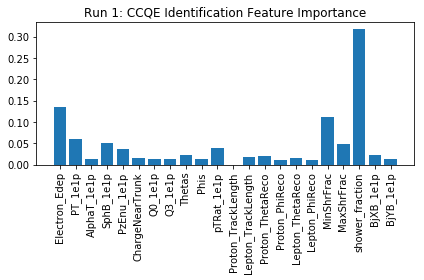

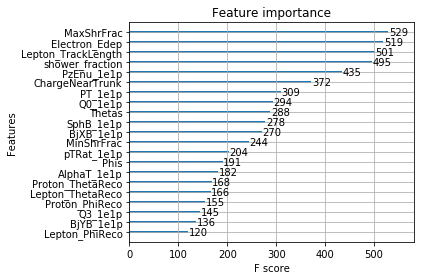

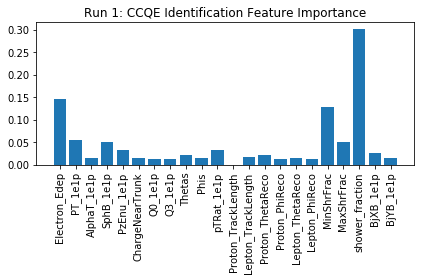

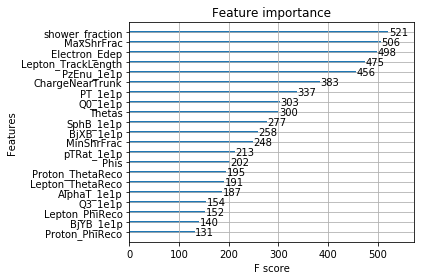

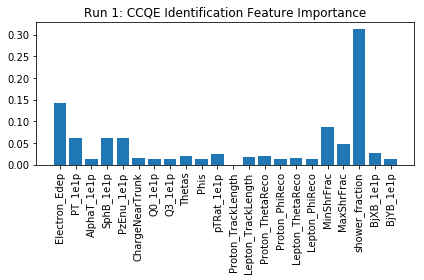

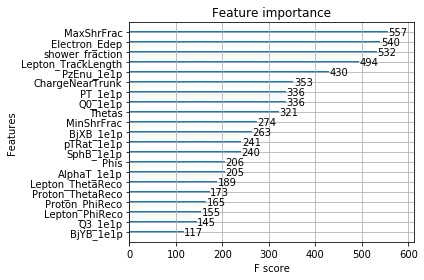

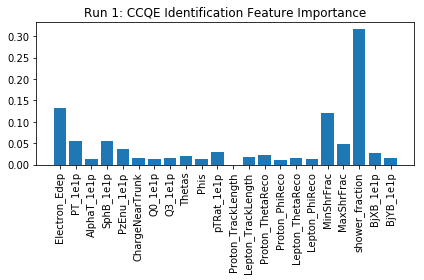

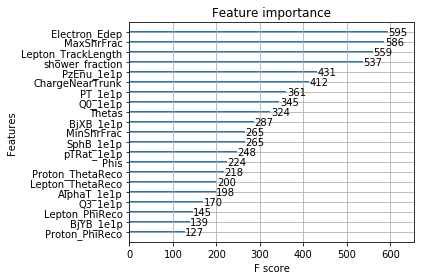

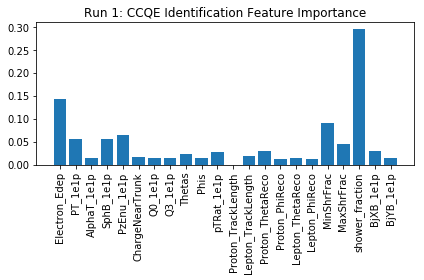

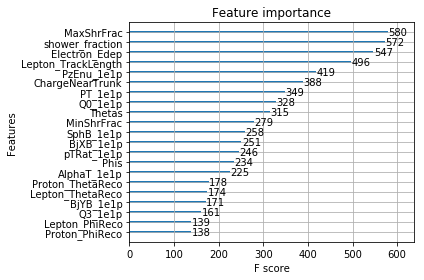

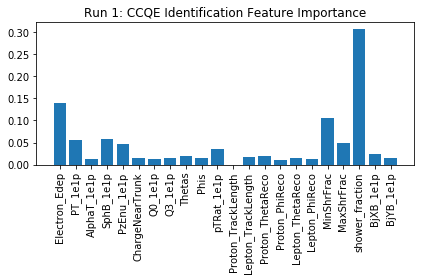

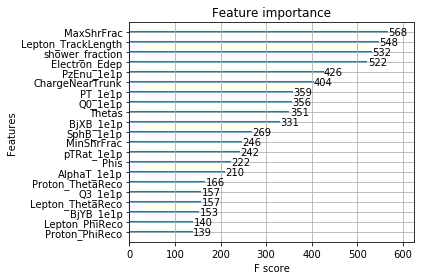

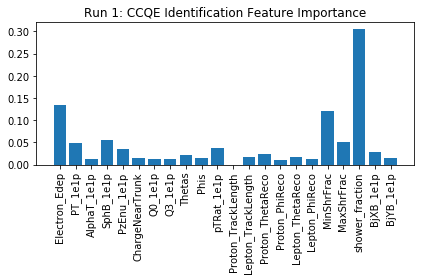

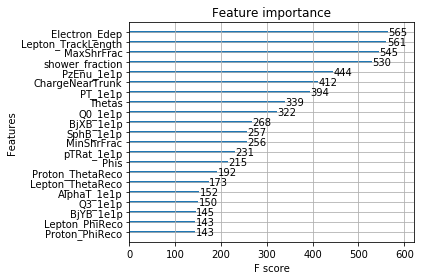

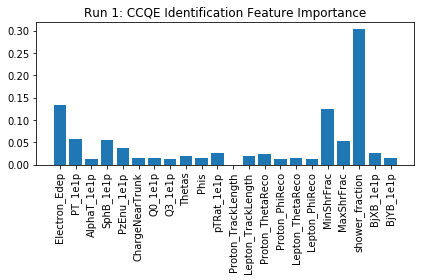

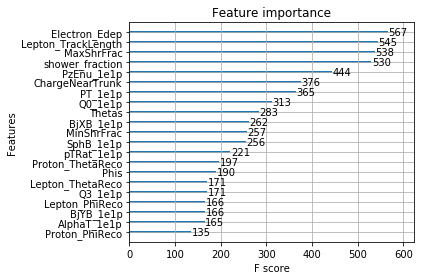

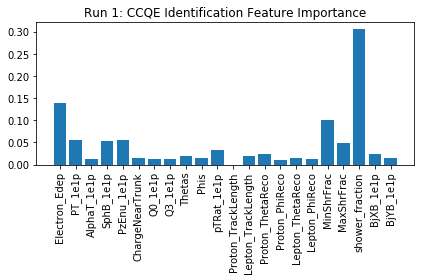

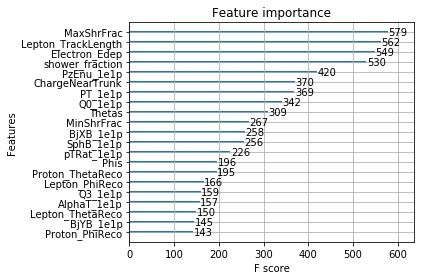

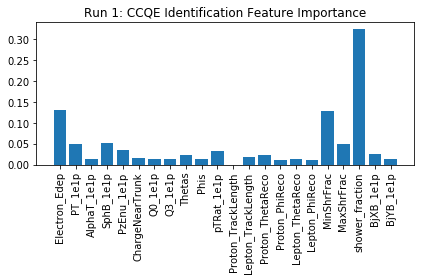

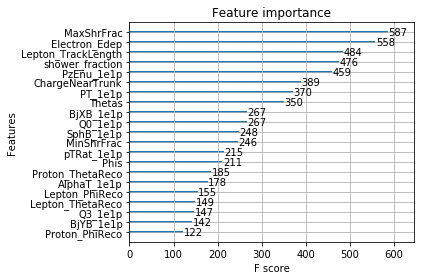

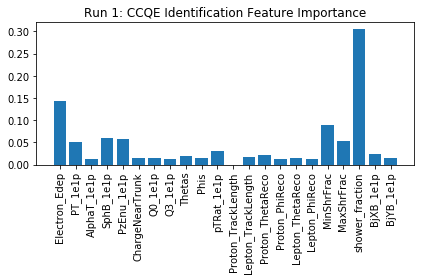

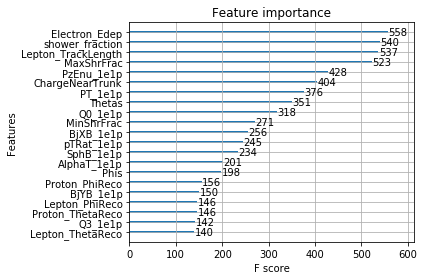

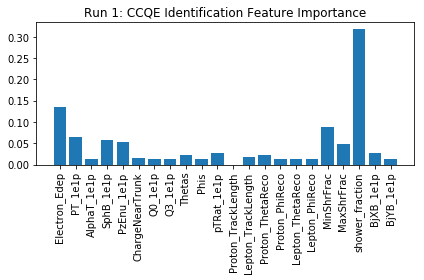

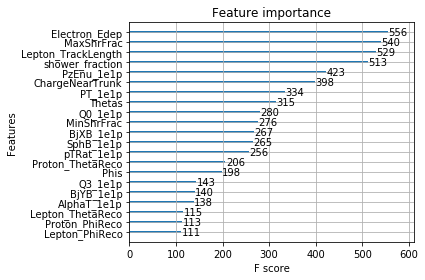

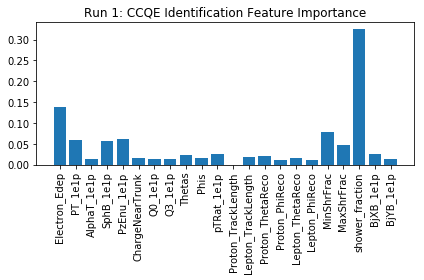

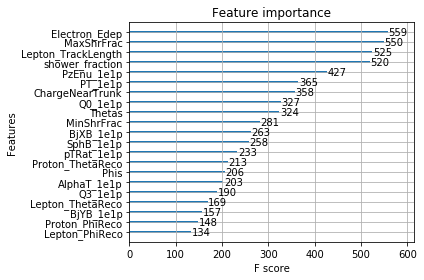

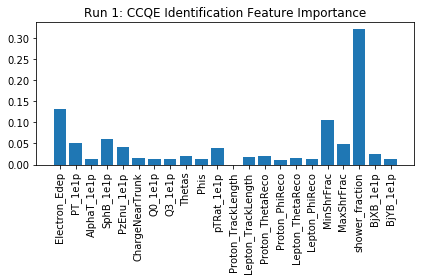

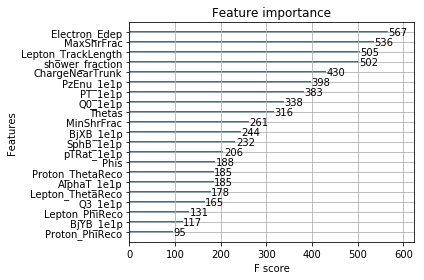

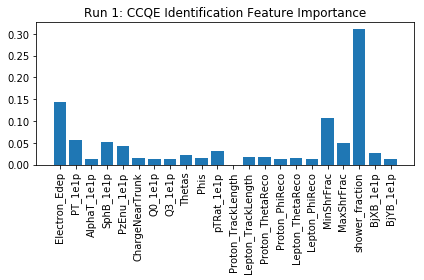

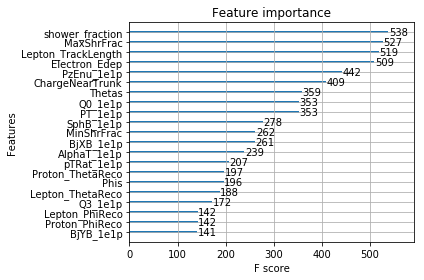

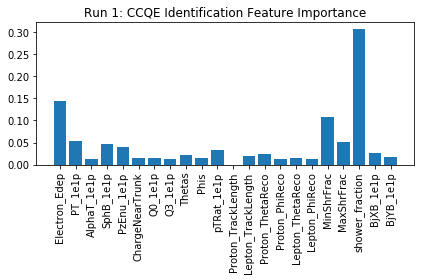

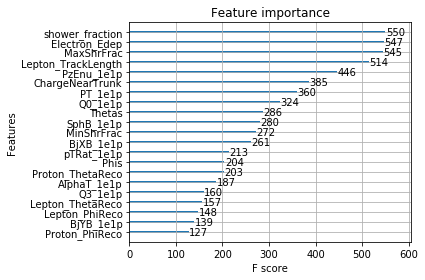

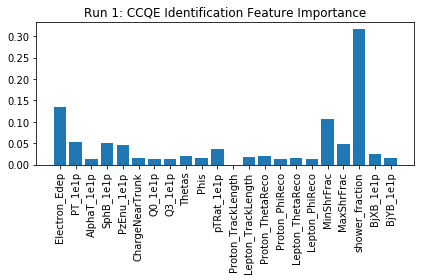

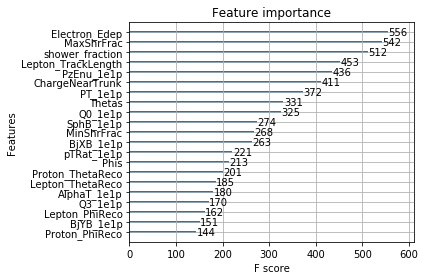

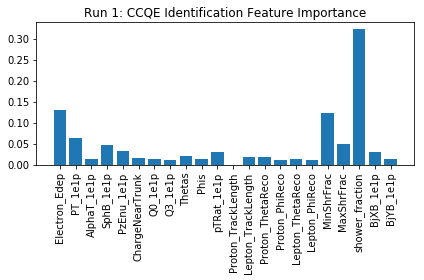

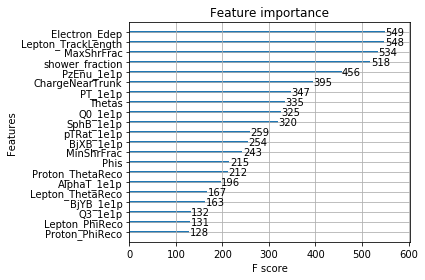

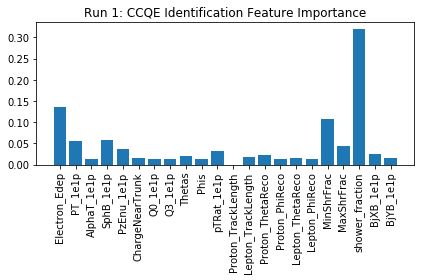

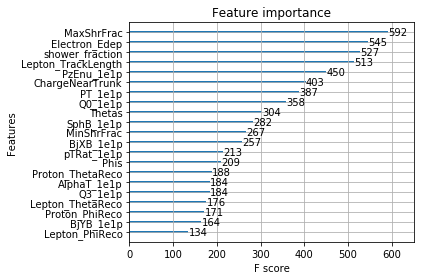

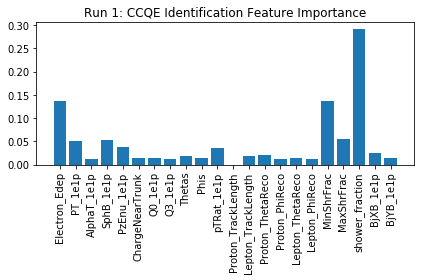

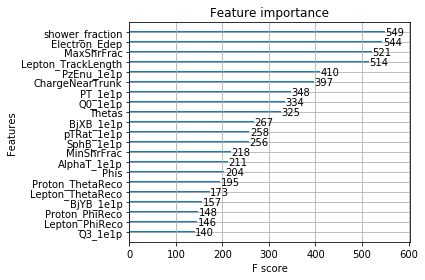

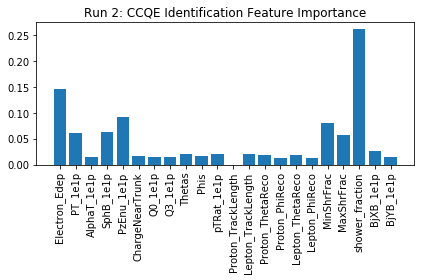

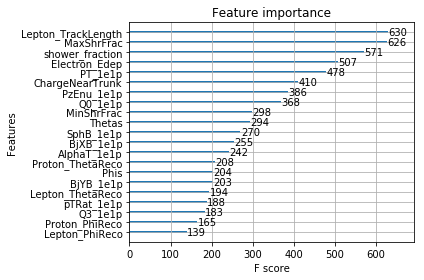

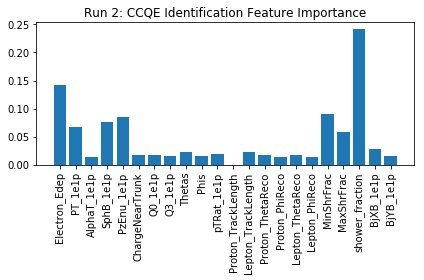

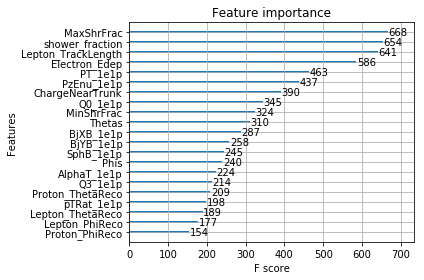

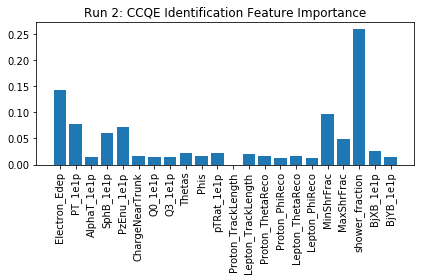

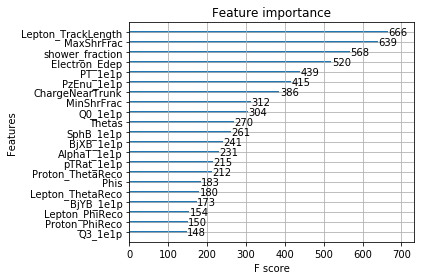

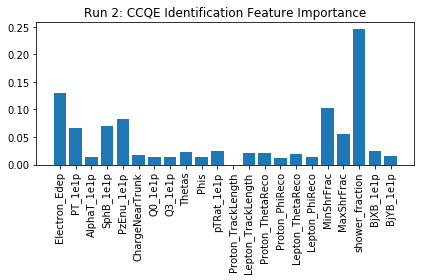

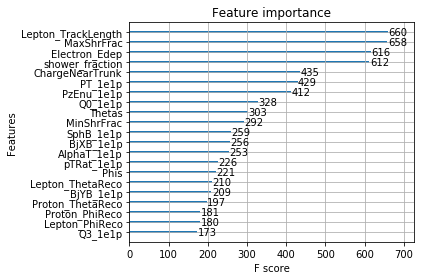

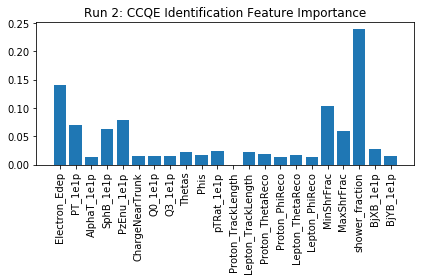

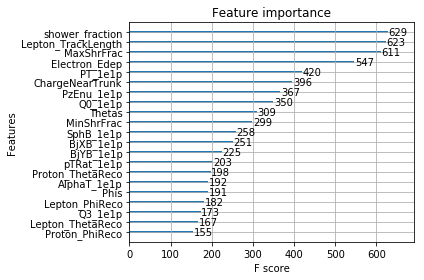

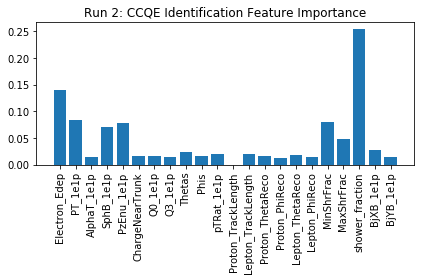

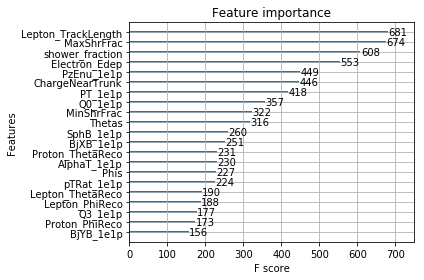

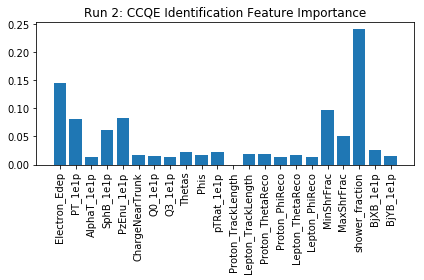

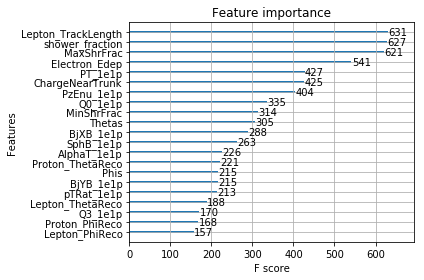

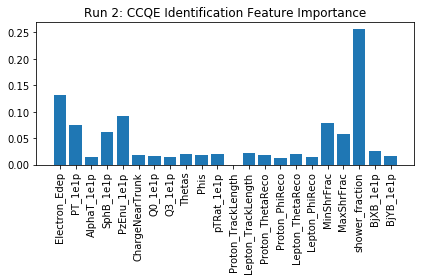

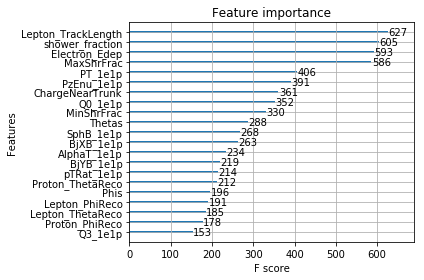

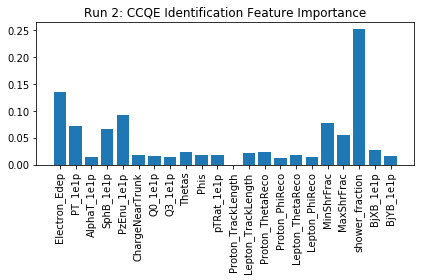

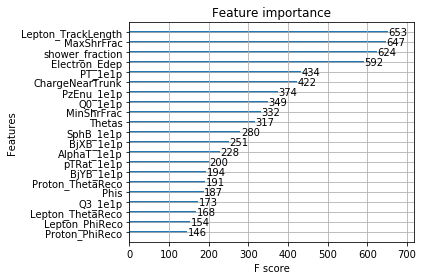

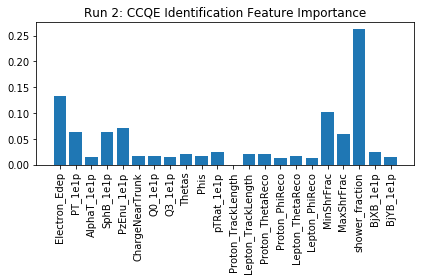

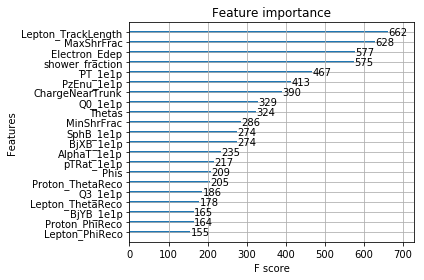

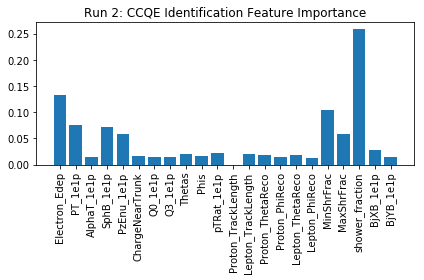

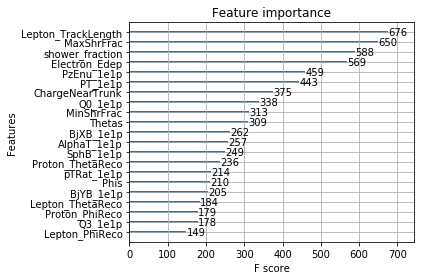

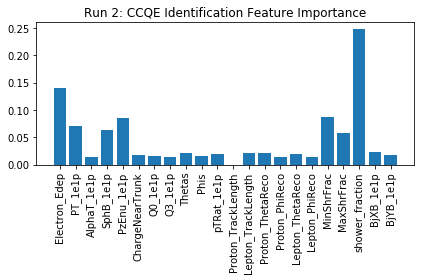

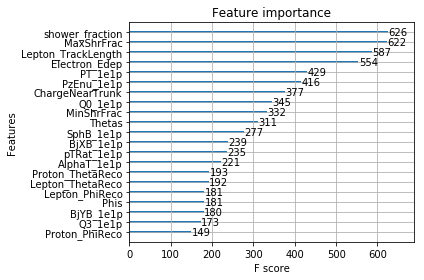

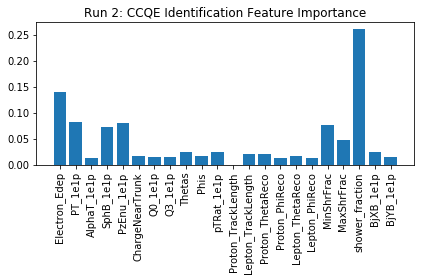

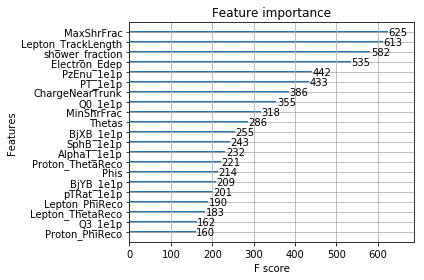

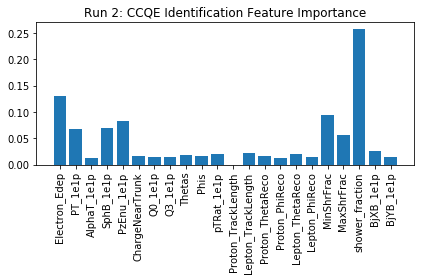

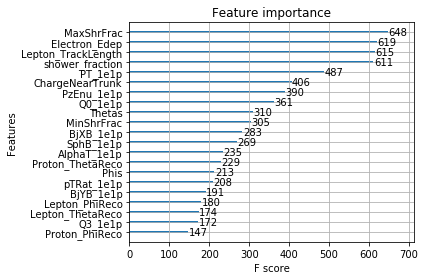

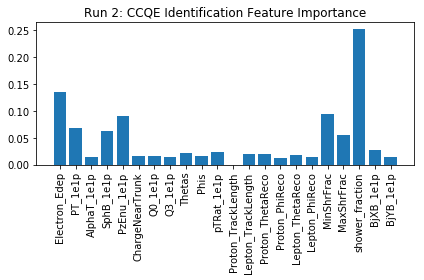

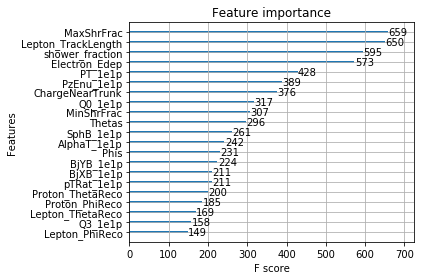

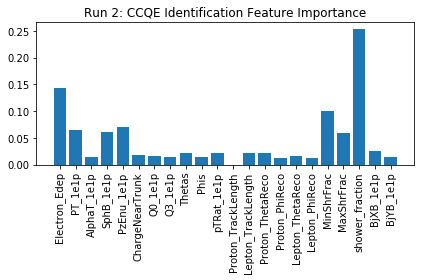

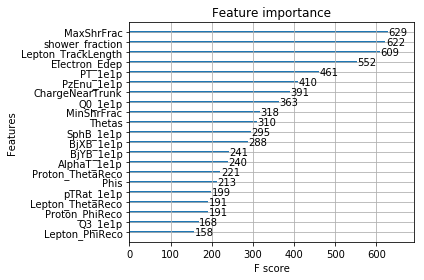

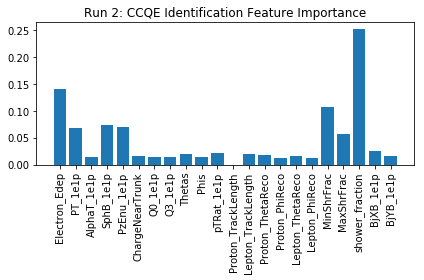

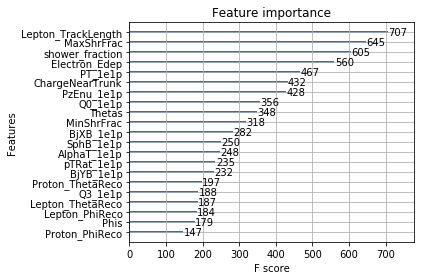

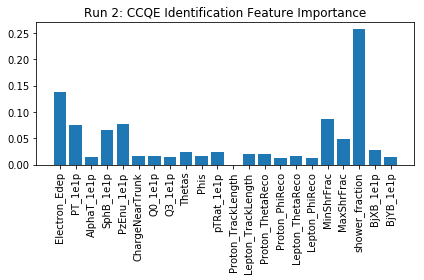

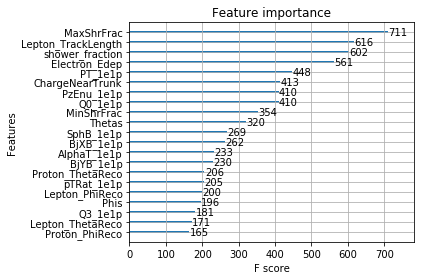

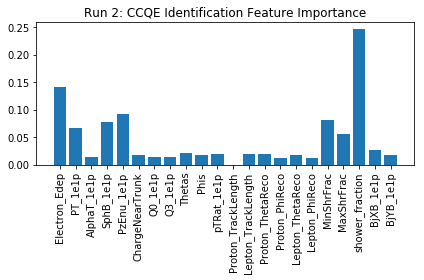

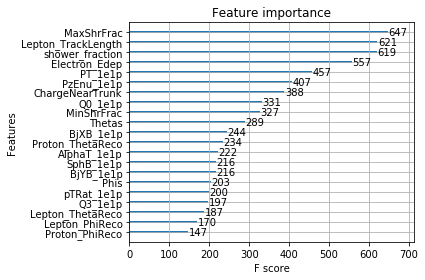

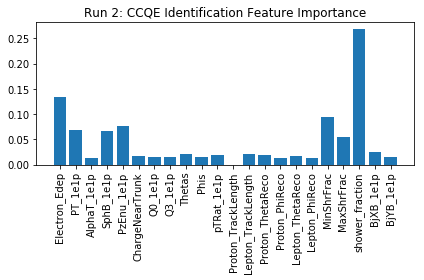

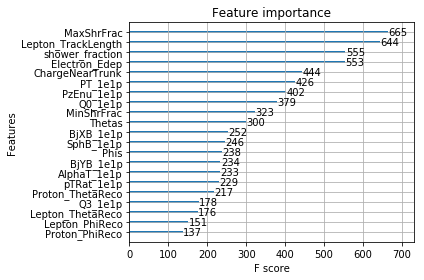

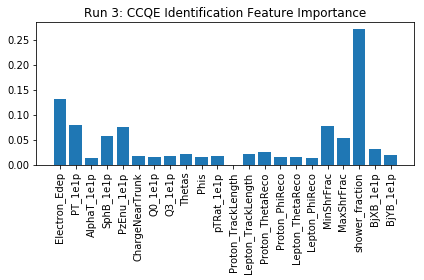

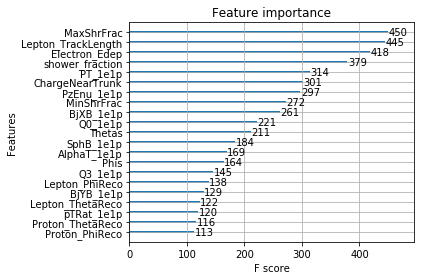

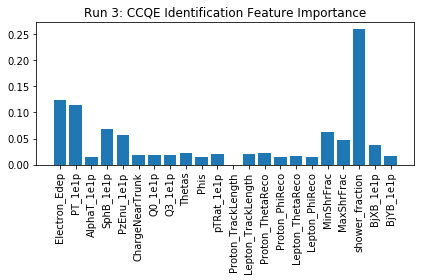

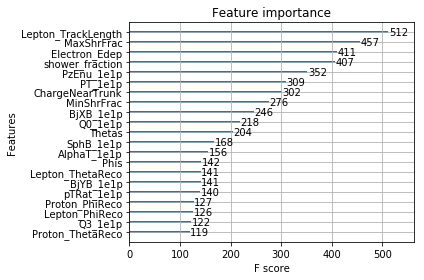

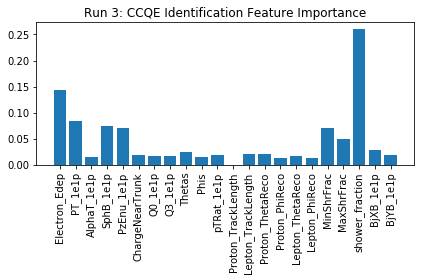

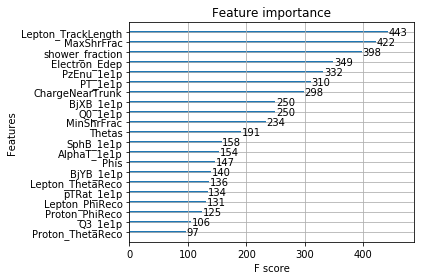

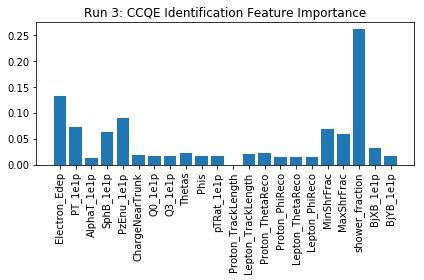

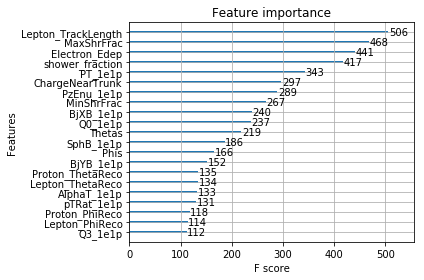

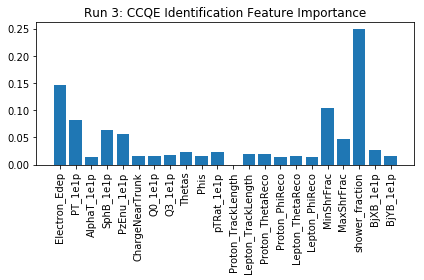

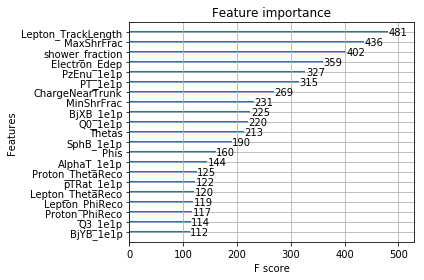

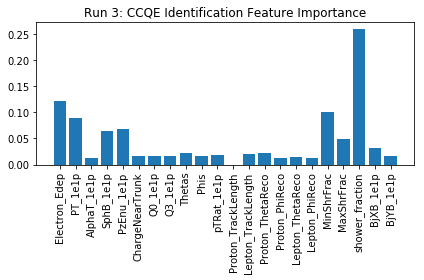

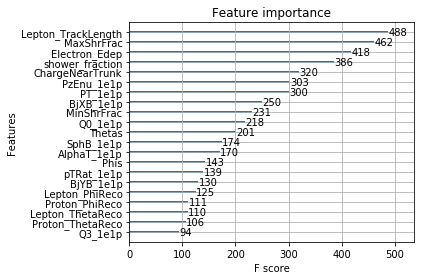

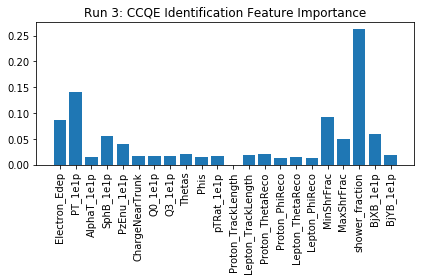

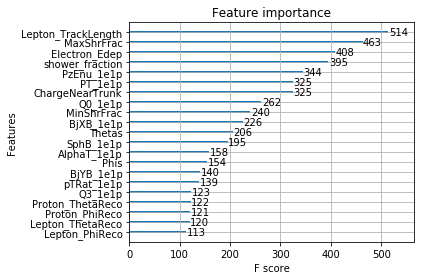

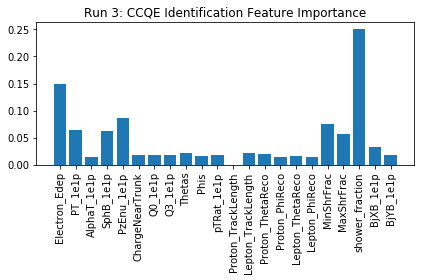

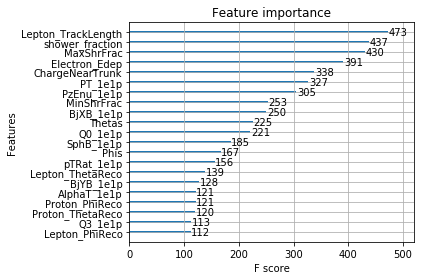

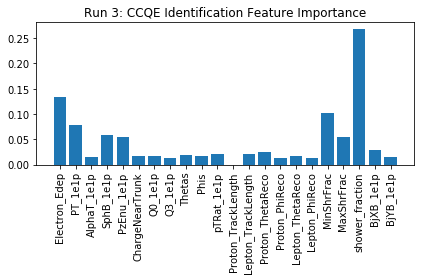

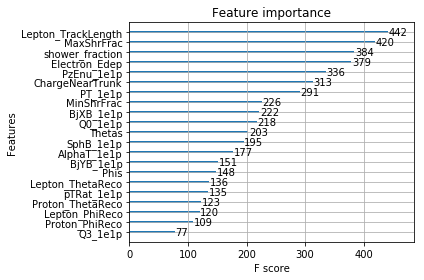

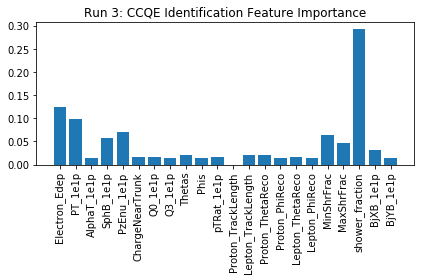

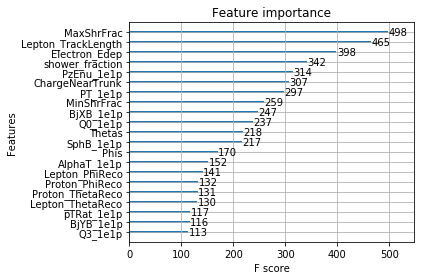

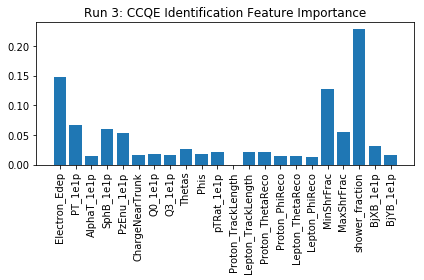

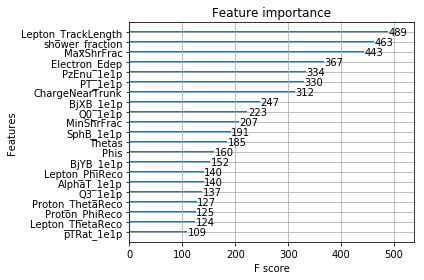

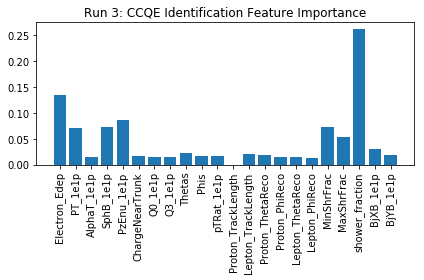

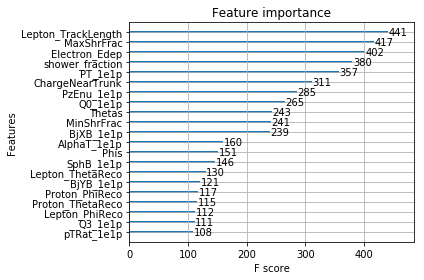

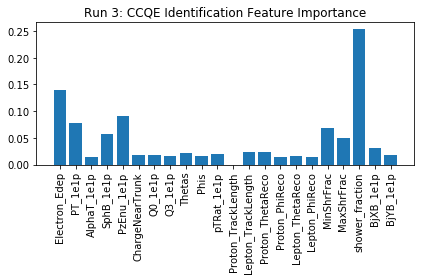

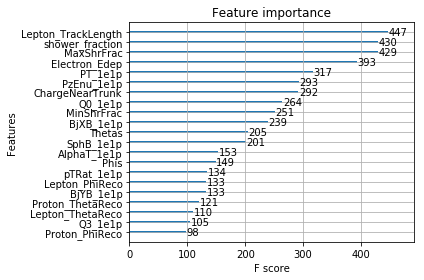

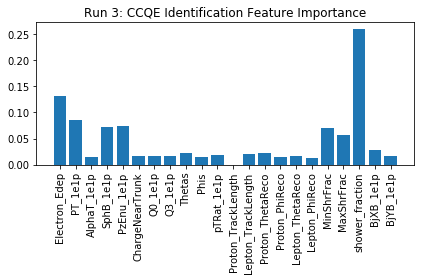

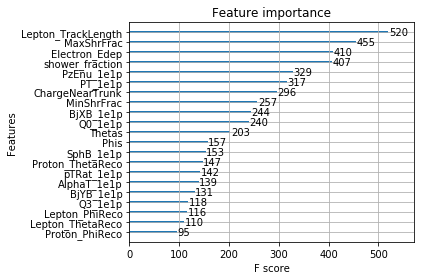

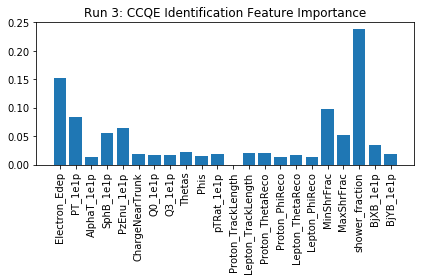

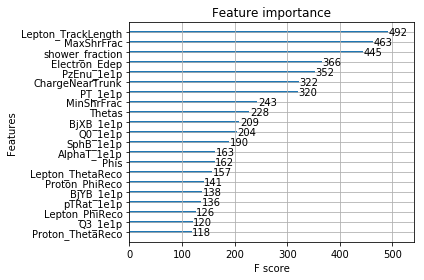

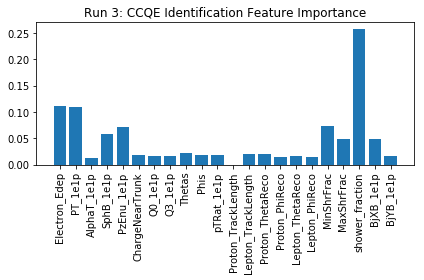

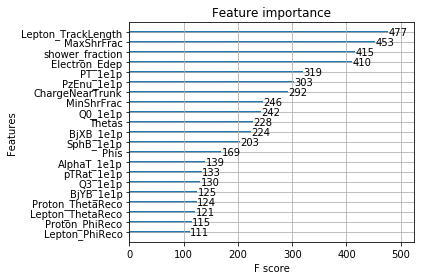

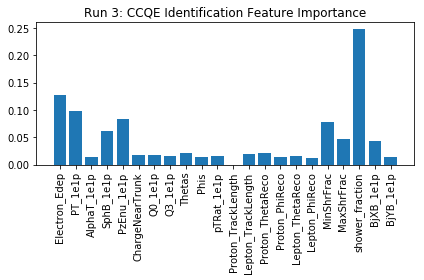

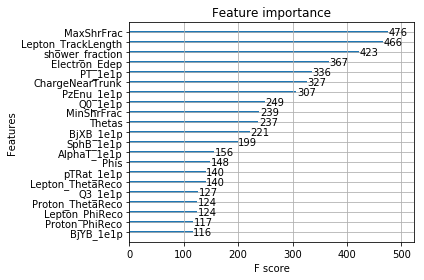

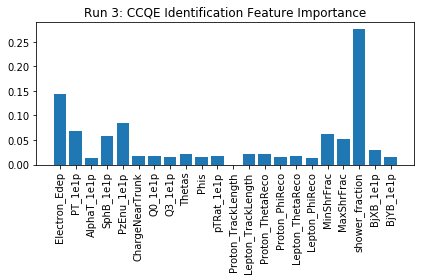

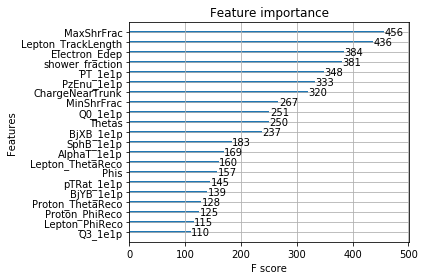

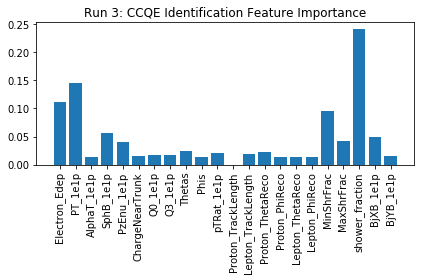

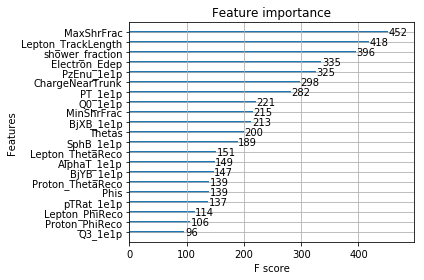

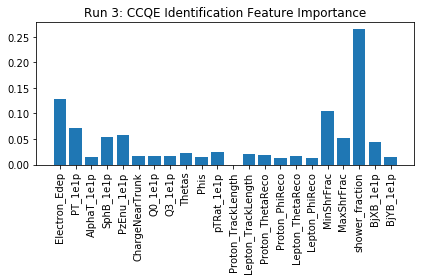

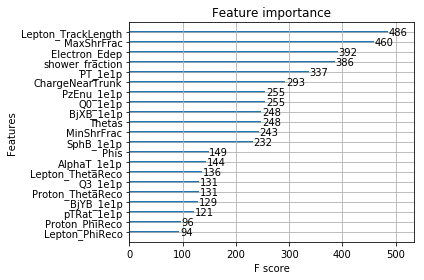

In [18]:
savedir = 'Plots/'+dirtag+'/FeatureImportances/'
try:
    os.mkdir(savedir)
except OSError as error:
    print(error)

# Feature importance 
from xgboost import plot_importance
variableTitles = ['Enu_1e1p', 'Electron_Edep', 'PT_1e1p', 'AlphaT_1e1p', 'SphB_1e1p', 'PzEnu_1e1p', 'ChargeNearTrunk',
            'Q0_1e1p', 'Q3_1e1p', 'Thetas', 'Phis', 'pTRat_1e1p', 'Proton_TrackLength', 'Lepton_TrackLength',
            'Proton_ThetaReco', 'Proton_PhiReco', 'Lepton_ThetaReco', 'Lepton_PhiReco', 'MinShrFrac',
            'MaxShrFrac','shower_fraction' , 'BjXB_1e1p', 'BjYB_1e1p']

if not useEnu:
    variableTitles = variableTitles[1:]

for r in [1,2,3]:
    for b in range(nBDTs):
        bdt[r][b].model.get_booster().feature_names = variableTitles
        plt.bar(range(len(bdt[r][b].model.feature_importances_)), bdt[r][b].model.feature_importances_)
        plt.xticks([x for x in range(len(bdt[r][b].model.feature_importances_))],variableTitles,rotation = 90)
        plt.title("Run %i: CCQE Identification Feature Importance" % r)
        plt.tight_layout()
        plt.savefig(savedir+'Gain_run%i_%i'%(r,b),dpi=100)
        plt.show()

        plot_importance(bdt[r][b].model)
        plt.tight_layout()
        plt.savefig(savedir+'Fscore_run%i_%i'%(r,b),dpi=100)
        plt.show()